In [200]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [201]:

data = pd.read_csv("../data/processed/apple.csv", index_col="Date")
if data.isna().any().any():
    print("Data contains NaN values. Please handle them before proceeding.")
    print(data[data.isna().any(axis=1)])
if (data == float('inf')).any().any() or (data == float('-inf')).any().any():
    data = data.replace([float('inf'), float('-inf')], None)
    data = data.dropna()
    
# data = data[:4000]


# print(data.shape)

x = data.iloc[:, :data.shape[1] - 1].values
y = data.iloc[:, data.shape[1] - 1].values

split = int(data.shape[0] * 0.95)

train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split:, ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (7553, 39) trainY: (7553,)
testX: (398, 39) testY: (398,)


In [202]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [203]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([39, 400, 400, 400, 10], 10)

[1/300] Loss: 1667.0237630605698
[2/300] Loss: 1542.9470233917236
[3/300] Loss: 1469.7949681282043
[4/300] Loss: 1402.7217103242874
[5/300] Loss: 1334.6801645755768
[6/300] Loss: 1284.8024938106537
[7/300] Loss: 1233.5936992764473
[8/300] Loss: 1176.33449280262
[9/300] Loss: 1124.4362709522247
[10/300] Loss: 1081.4224816560745
[11/300] Loss: 1021.0331084728241
[12/300] Loss: 982.6499141454697
[13/300] Loss: 930.8610244989395
[14/300] Loss: 884.564601957798
[15/300] Loss: 845.5427378416061
[16/300] Loss: 790.3311069011688
[17/300] Loss: 750.0599327087402
[18/300] Loss: 708.7474175691605
[19/300] Loss: 661.6213412284851
[20/300] Loss: 619.5139491558075
[21/300] Loss: 584.7420343160629
[22/300] Loss: 545.9265966415405
[23/300] Loss: 503.5005376338959
[24/300] Loss: 466.44709026813507
[25/300] Loss: 433.014901638031
[26/300] Loss: 397.0546040534973
[27/300] Loss: 360.6163817644119
[28/300] Loss: 331.5463854074478
[29/300] Loss: 308.69575196504593
[30/300] Loss: 283.4328157901764
[31/300] L

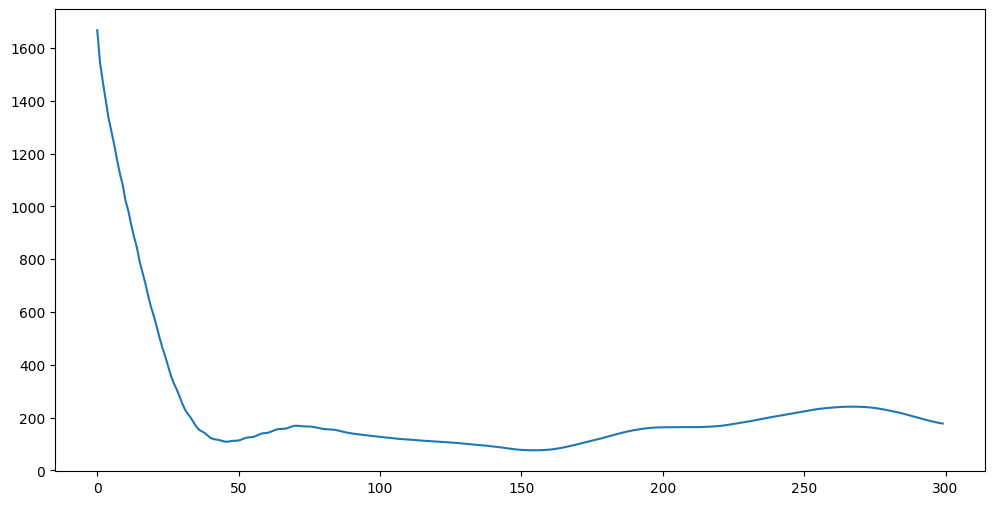

In [204]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [205]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [206]:

def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float() 
    return x_, y_
     

In [207]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [208]:
train_x_slide, train_y_slide = sliding_window(train_x, train_y, 20)
test_x_slide, test_y_slide = sliding_window(test_x, test_y, 20)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape}')

train_x: torch.Size([7533, 20, 49]) train_y: torch.Size([7533, 1])
test_x: torch.Size([378, 20, 49]) test_y: torch.Size([378, 1])


In [209]:
class StockTransformer(nn.Module):
    def __init__(self, feature_dim, seq_len, target_dim, d_model=256, num_heads=4, num_layers=3, ff_dim=256, dropout=0.3):
        super(StockTransformer, self).__init__()
        
        self.input_embedding = nn.Linear(feature_dim, d_model)
        
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, target_dim)
        )

    def forward(self, x):
        x = self.input_embedding(x) 
        x = x + self.positional_encoding[:, :x.size(1), :] 
        
        
        x = x.permute(1, 0, 2) 
        
        
        encoded = self.transformer_encoder(x) 
        
        output = encoded[-1, :, :] 
        
        output = self.fc(output) 
        return output

In [210]:
import torch.optim as optim

model = StockTransformer(feature_dim=49, seq_len=20, target_dim=1, num_heads=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/Users/huynhnguyen/Stock-Prediction-Deep-Learning/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [211]:
num_epochs = 30
batch_size = 256


train_dataset = torch.utils.data.TensorDataset(train_x_slide, train_y_slide)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    hist[epoch] = epoch_loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader)}")

    model.eval()
    with torch.no_grad():
        test_predictions = model(test_x_slide)
        test_loss = criterion(test_predictions, test_y_slide)
        print(f"Test Loss: {test_loss.item()}")

Epoch [1/30], Loss: 0.017833675273383656
Test Loss: 0.04282936826348305
Epoch [2/30], Loss: 0.005272212515895565
Test Loss: 0.04390478879213333
Epoch [3/30], Loss: 0.003812857282658418
Test Loss: 0.03615124523639679
Epoch [4/30], Loss: 0.0037156529802208145
Test Loss: 0.03165658190846443
Epoch [5/30], Loss: 0.003202851659928759
Test Loss: 0.027324391528964043
Epoch [6/30], Loss: 0.0030755938651661078
Test Loss: 0.026505902409553528
Epoch [7/30], Loss: 0.00277972772407035
Test Loss: 0.028011538088321686
Epoch [8/30], Loss: 0.0027555445674806835
Test Loss: 0.025389427319169044
Epoch [9/30], Loss: 0.0028092646505683662
Test Loss: 0.023872138932347298
Epoch [10/30], Loss: 0.0024540626793168483
Test Loss: 0.02495459094643593
Epoch [11/30], Loss: 0.0022860924984949333
Test Loss: 0.02460385300219059
Epoch [12/30], Loss: 0.0024421280987250308
Test Loss: 0.023886490613222122
Epoch [13/30], Loss: 0.0022727416129782797
Test Loss: 0.025758571922779083
Epoch [14/30], Loss: 0.0021520279192676147
Tes

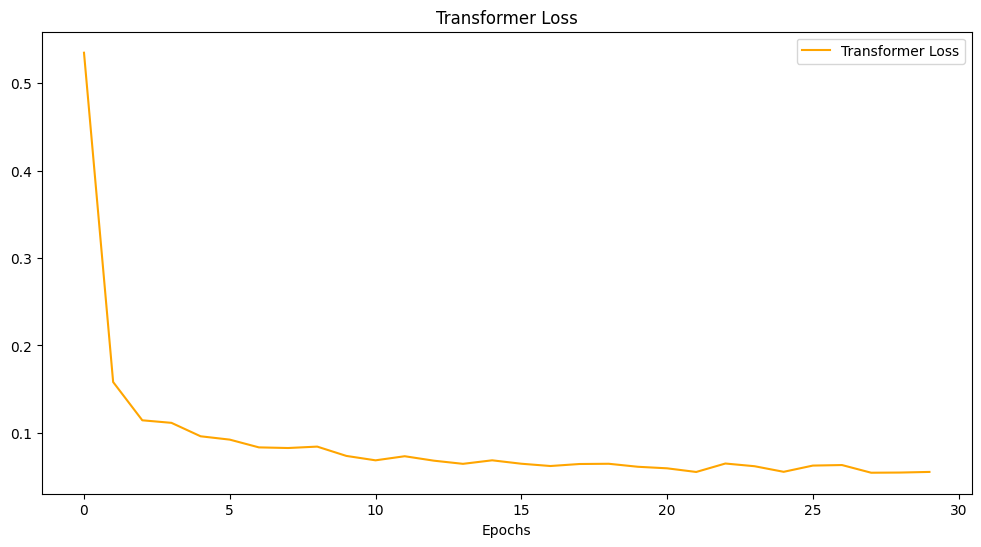

In [212]:
plt.figure(figsize = (12, 6))
plt.plot(hist, color = 'orange', label = 'Transformer Loss')
plt.title('Transformer Loss')
plt.xlabel('Epochs')
plt.legend(loc = 'upper right')
plt.savefig("./transformer_image/transformer_with_vae_loss.png")

In [213]:
model.eval()
pred_y_train = model(train_x_slide.to(device))
pred_y_test = model(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:2.245989210461276


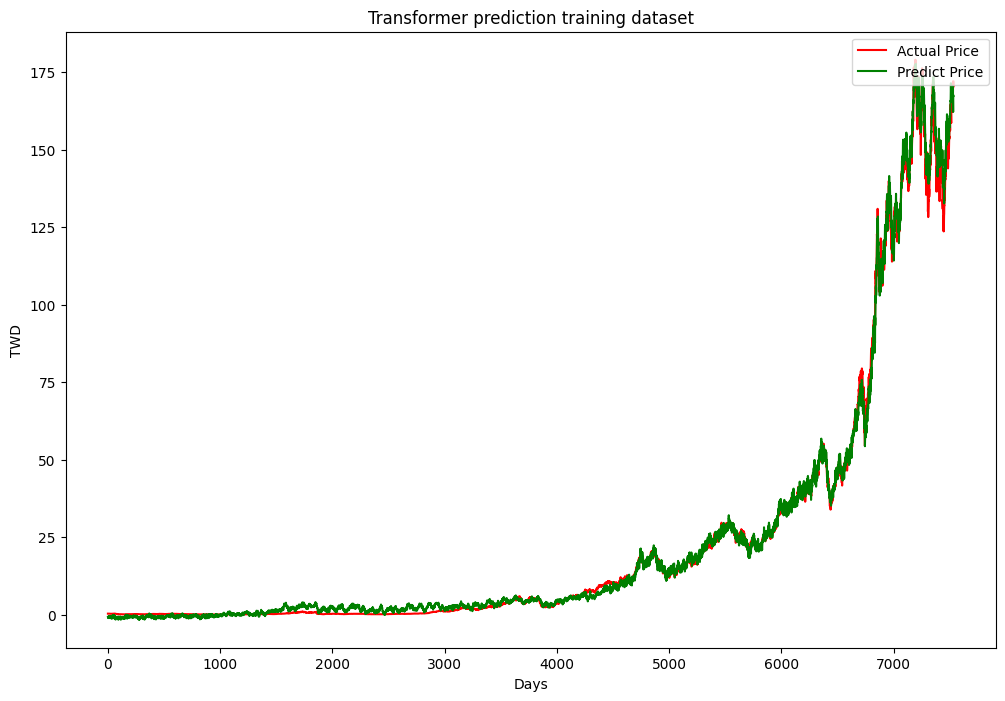

In [214]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'red', label = 'Actual Price')
plt.plot(y_train_pred, color = 'green', label = 'Predict Price')
plt.title('Transformer prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
plt.savefig("./transformer_image/transformer_with_vae_train.png")

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:12.855530913026097


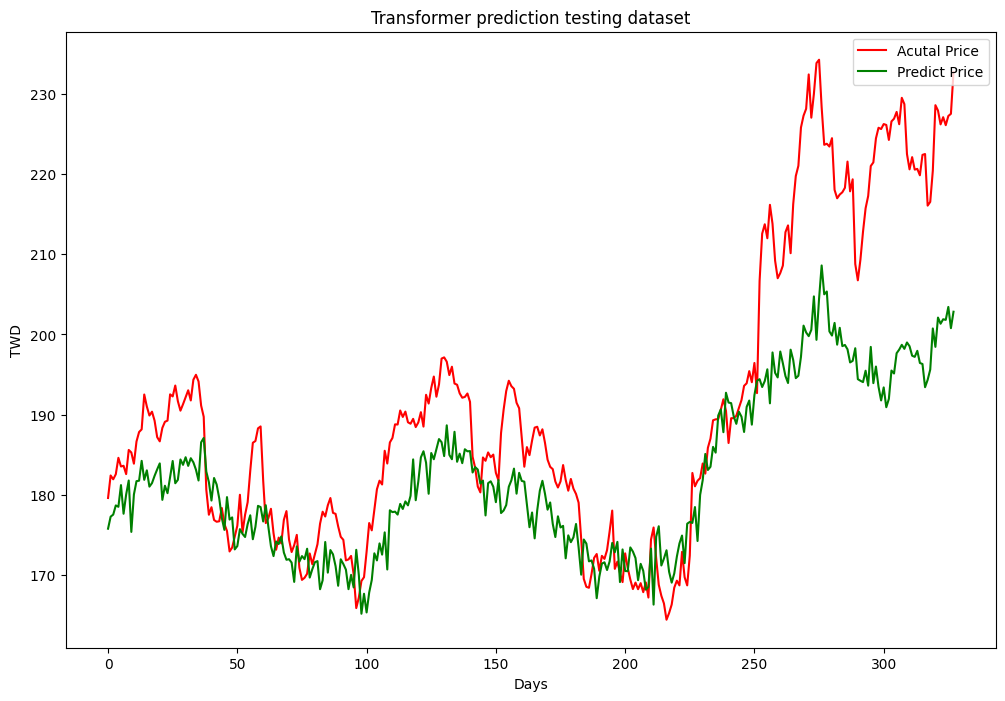

In [215]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true[:-50], color = 'red', label = 'Acutal Price')
plt.plot(y_test_pred[:-50], color = 'green', label = 'Predict Price')
plt.title('Transformer prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
plt.savefig("./transformer_image/transformer_with_vae_test.png")

MSE = mean_squared_error(y_test_true[:-50], y_test_pred[:-50])
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [216]:
torch.save(model.state_dict(), './models/transformer_model.pt')

# Without VAE

In [217]:
data = pd.read_csv("../data/processed/apple.csv", index_col="Date")
if data.isna().any().any():
    print("Data contains NaN values. Please handle them before proceeding.")
    print(data[data.isna().any(axis=1)])
if (data == float('inf')).any().any() or (data == float('-inf')).any().any():
    data = data.replace([float('inf'), float('-inf')], None)
    data = data.dropna()
    
# data = data[:4000]


# print(data.shape)

x = data.iloc[:, :data.shape[1] - 1].values
y = data.iloc[:, data.shape[1] - 1].values

split = int(data.shape[0] * 0.95)
split2 = 70

train_x, test_x = x[: split, :], x[split + split2:, :]
train_y, test_y = y[: split, ], y[split + split2:, ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (7553, 39) trainY: (7553,)
testX: (328, 39) testY: (328,)


In [218]:
train_x_slide, train_y_slide = sliding_window(train_x, train_y, 20)
test_x_slide, test_y_slide = sliding_window(test_x, test_y, 20)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape}')

train_x: torch.Size([7533, 20, 39]) train_y: torch.Size([7533, 1])
test_x: torch.Size([308, 20, 39]) test_y: torch.Size([308, 1])


In [219]:
import torch.optim as optim

model = StockTransformer(feature_dim=39, seq_len=20, target_dim=1, num_heads=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/Users/huynhnguyen/Stock-Prediction-Deep-Learning/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [220]:
num_epochs = 30
batch_size = 256


train_dataset = torch.utils.data.TensorDataset(train_x_slide, train_y_slide)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    hist[epoch] = epoch_loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader)}")

    model.eval()
    with torch.no_grad():
        test_predictions = model(test_x_slide)
        test_loss = criterion(test_predictions, test_y_slide)
        print(f"Test Loss: {test_loss.item()}")

Epoch [1/30], Loss: 0.03390434666847189
Test Loss: 0.09902404993772507
Epoch [2/30], Loss: 0.0058446867857128385
Test Loss: 0.07213027775287628
Epoch [3/30], Loss: 0.004452362571222087
Test Loss: 0.0590084046125412
Epoch [4/30], Loss: 0.003940982037844757
Test Loss: 0.06008198857307434
Epoch [5/30], Loss: 0.0034961580531671643
Test Loss: 0.05432070046663284
Epoch [6/30], Loss: 0.0032493098134485383
Test Loss: 0.06052698567509651
Epoch [7/30], Loss: 0.0031328201293945312
Test Loss: 0.0526420921087265
Epoch [8/30], Loss: 0.003053329865603397
Test Loss: 0.05738227441906929
Epoch [9/30], Loss: 0.0030845591992450256
Test Loss: 0.05647924914956093
Epoch [10/30], Loss: 0.0028869760455563663
Test Loss: 0.05629780516028404
Epoch [11/30], Loss: 0.002749445871450007
Test Loss: 0.05267425626516342
Epoch [12/30], Loss: 0.0027015630970709027
Test Loss: 0.05589461699128151
Epoch [13/30], Loss: 0.002651528858890136
Test Loss: 0.053113505244255066
Epoch [14/30], Loss: 0.0024545717091920475
Test Loss: 0

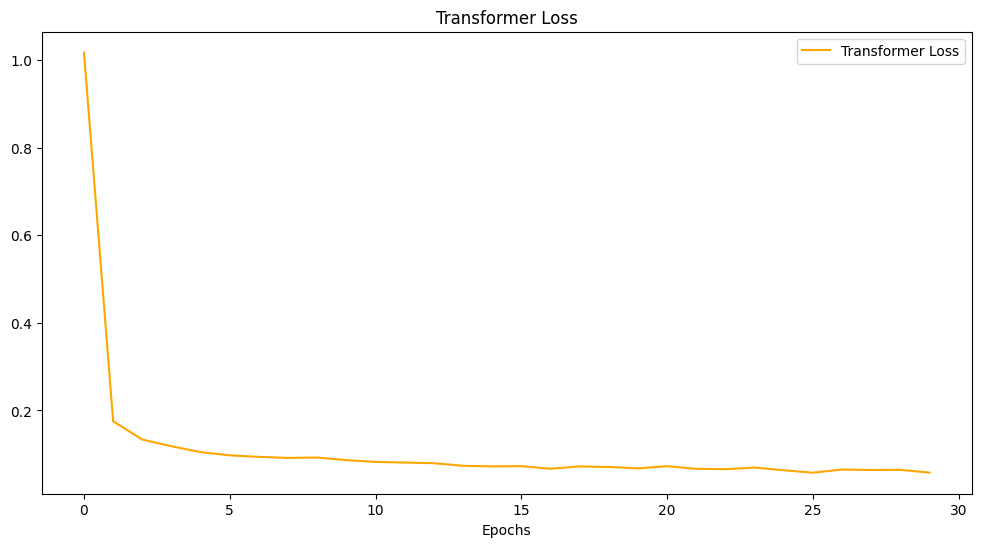

In [221]:
plt.figure(figsize = (12, 6))
plt.plot(hist, color = 'orange', label = 'Transformer Loss')
plt.title('Transformer Loss')
plt.xlabel('Epochs')
plt.legend(loc = 'upper right')
plt.savefig("./transformer_image/transformer_without_vae_loss.png")

In [222]:
model.eval()
pred_y_train = model(train_x_slide.to(device))
pred_y_test = model(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:3.520933613258063


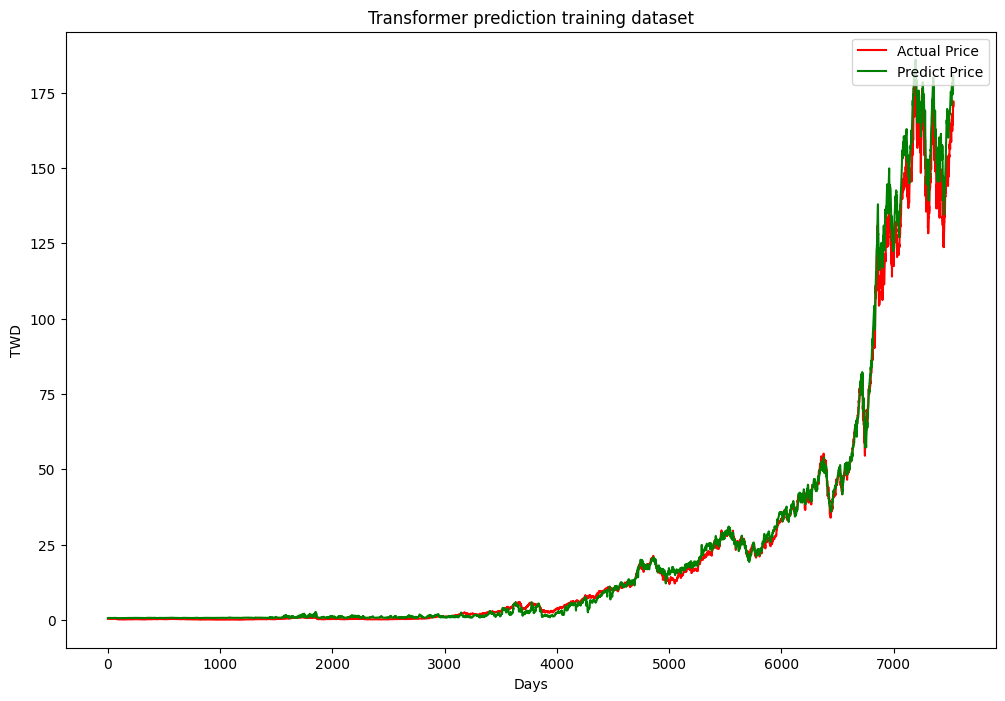

In [223]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'red', label = 'Actual Price')
plt.plot(y_train_pred, color = 'green', label = 'Predict Price')
plt.title('Transformer prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
plt.savefig("./transformer_image/transformer_without_vae_train.png")

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:15.17523308871994


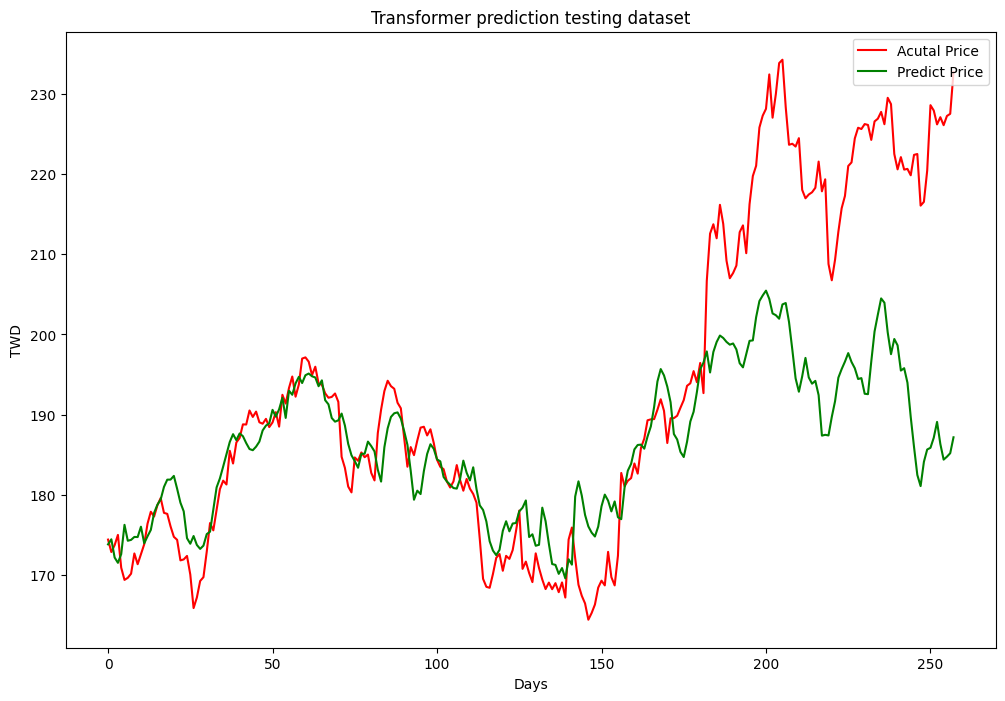

In [224]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true[:-50], color = 'red', label = 'Acutal Price')
plt.plot(y_test_pred[:-50], color = 'green', label = 'Predict Price')
plt.title('Transformer prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
plt.savefig("./transformer_image/transformer_without_vae_test.png")
MSE = mean_squared_error(y_test_true[:-50], y_test_pred[:-50])
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')